Context: This notebook outlines and visualizes the process in which we obtain tagboard in cam $T^{tagboard}_{camera}$

Author: Hameed Abdul (hameeda2@illinois.edu) 

In [1]:
# !pip install pupil_apriltags opencv-python==4.5.3.56 transforms3d
%matplotlib inline 
from pupil_apriltags import Detector
from matplotlib import pyplot as plt
from transforms3d.euler import euler2mat
import cv2
import numpy as np

import mrcnn.utils.visualization as vis

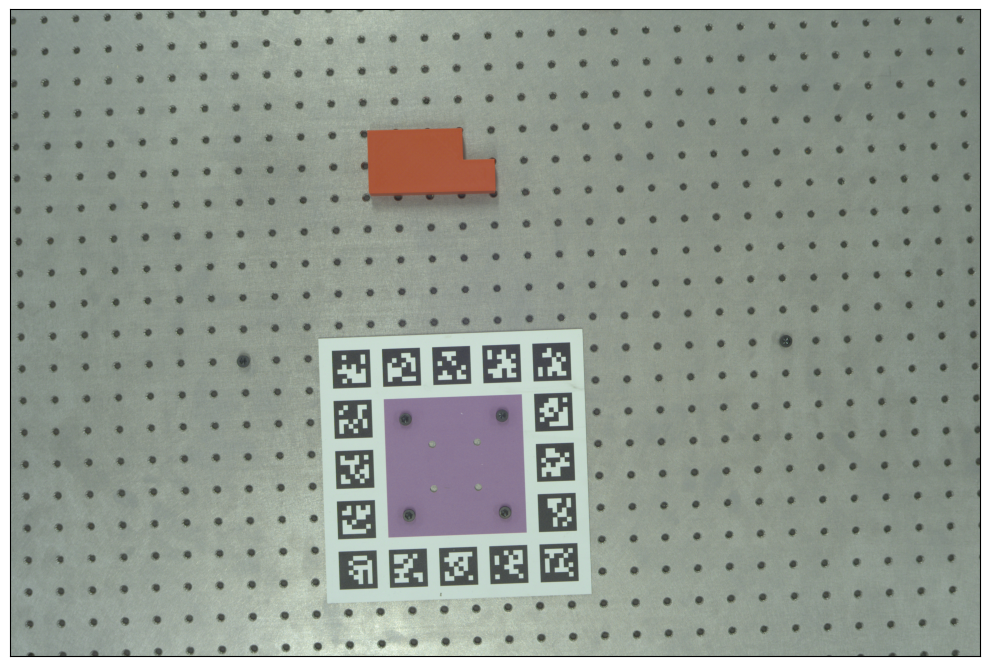

In [2]:

def plot_im_with_circle(img, ref, reproject, figsize=(10,10)):
    fig = plt.figure(figsize=figsize,tight_layout=True)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    fig.set_tight_layout(True)
    plt.imshow(img[:,:,::-1])
    
    for gt, pred in zip(ref, reproject):
        x_ref, y_ref = gt
        x, y = pred
        plt.plot(x_ref, y_ref, 'y.', markersize=16)
        plt.plot(x, y, 'r.', markersize=6)
        

def make_T(r, t):
    return np.block([[euler2mat(*r),t],
                     [np.zeros(3), 1]])

# Plot reference and reprojected pixels
def draw_axis(img, R, t, K, scale=0.1, dist=None):
    """
    Draw a 6dof axis (XYZ -> RGB) in the given rotation and translation
    :param img - rgb numpy array
    :R - Rotation matrix, 3x3
    :t - 3d translation vector, in meters (dtype must be float)
    :K - intrinsic calibration matrix , 3x3
    :scale - factor to control the axis lengths
    :dist - optional distortion coefficients, numpy array of length 4. If None distortion is ignored.
    """
    img = img[:,:,::-1].copy() 
    img = img.astype(np.float32)
    rotation_vec, _ = cv2.Rodrigues(R) #euler rotations
    dist = np.zeros(4, dtype=float) if dist is None else dist
    points = scale * np.float32([[1, 0, 1], [0, 1, 1], [0, 0, 1], [0, 0, 1]]).reshape(-1, 3)
    axis_points, _ = cv2.projectPoints(points, rotation_vec, t, K, dist)
    
    axis_points = axis_points.astype(int)
    corner = tuple(axis_points[3].ravel())
    R, G, B = (255, 0, 0), (0, 255, 0), (0, 0, 255)
    img = cv2.line(img, corner, tuple(axis_points[0].ravel()), R, 30)
    img = cv2.putText(img, "X", tuple(axis_points[0].ravel()), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 15)

    img = cv2.line(img, corner, tuple(axis_points[1].ravel()), G, 30)
    img = cv2.putText(img, "Y", tuple(axis_points[1].ravel()), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 15)

    img = cv2.line(img, corner, tuple(axis_points[2].ravel()), B, 30)
    z_offset_pos = axis_points[2].ravel()
    z_offset_pos[1] -= 20
    z_offset_pos[1] += 180
    img = cv2.putText(img, "Z", tuple(z_offset_pos), cv2.FONT_HERSHEY_SIMPLEX, 5, B, 15)
    # img = cv2.arrowedLine(img, axis_points[2].ravel(), axis_points[2].ravel(), B, 5, tipLength=0.1)
    img = cv2.line(img, corner, tuple(axis_points[2].ravel()), B, 30)
    img = img.astype(np.uint8)
    return img[:,:,::-1]

    
# Camera Intrinsics
# Instrinsics April 2023 - 25mm lens
# See https://github.com/cobot-factory/ur5e_collab_ws/blob/main/src/cobot_resources/camera/basler_25mm_intrinsics_April.28.23.yaml
camera = {
    "fx": 10704.062350, 
    "fy": 10727.438047, 
    "ox": 2694.112343, 
    "oy": 1669.169773, 
    "w": 5472, 
    "h": 3648 
}

K = np.stack([[camera['fx'], 0, camera['ox']],
              [0, camera['fy'], camera['oy']],
              [0,            0,           1]])

camera_params = [camera['fx'], camera['fy'], camera['ox'], camera['oy']]
distortion_coefficients = np.array([0.007919, -0.388861, -0.002665, 0.003248, 0.000000])


# Camera Extrinsics October 2023 - 
# IMG_PATH = "./test_img.png" # Image was captured with extrinsic below...
IMG_PATH = "./T_tagboard_in_cam.png"
# T_camera_in_base = np.array([[-0.9993267 ,  0.03599175, -0.00712337, -0.70197483],
#                              [ 0.0362479 ,  0.998547  , -0.03987449,  0.00844085],
#                              [ 0.00567786, -0.04010585, -0.9991793 ,  1.49442875],
#                              [ 0.        ,  0.        ,  0.        ,  1.        ]])

T_base_in_cam = np.array([[-0.9993087 ,  0.03672612,  0.00577244, -0.71203529],
                     [ 0.03646547,  0.99852782, -0.04015546,  0.07646915],
                     [-0.0072387 , -0.0399172 , -0.99917677,  1.4886157 ],
                     [ 0.        ,  0.        ,  0.        ,  1.        ]])

T_camera_in_base = np.linalg.inv(T_base_in_cam)

img = cv2.imread(IMG_PATH)
vis.plot_im(IMG_PATH)

## Tagboard coordinates
This is the template for 8.27" x 8.27" x 0.125" aluminum board with a unique 5x5 april tag pattern.
The innermost 3x3 tags were removed and covered with a colored square.
    
This was generated with:
- this code: https://github.com/cobot-factory/extrinsic_calibration
- this cmd: `python make_tagboard_with_ws.py ./test.pdf --nx 5 --ny 5 --tag_color 'Black' --ws_color 'Orchid' --tsize 0.03 --tspace 0.33 --borderbits 1 --add_screw_holes True`
- this is an example: https://github.com/cobot-factory/extrinsic_calibration/blob/main/apriltagboard/test.pdf
- pdf was printed on alluminium through: https://www.foamcoreprint.com/apriltag-targets

Below is an image of the tagboard printed to spec:
<!-- 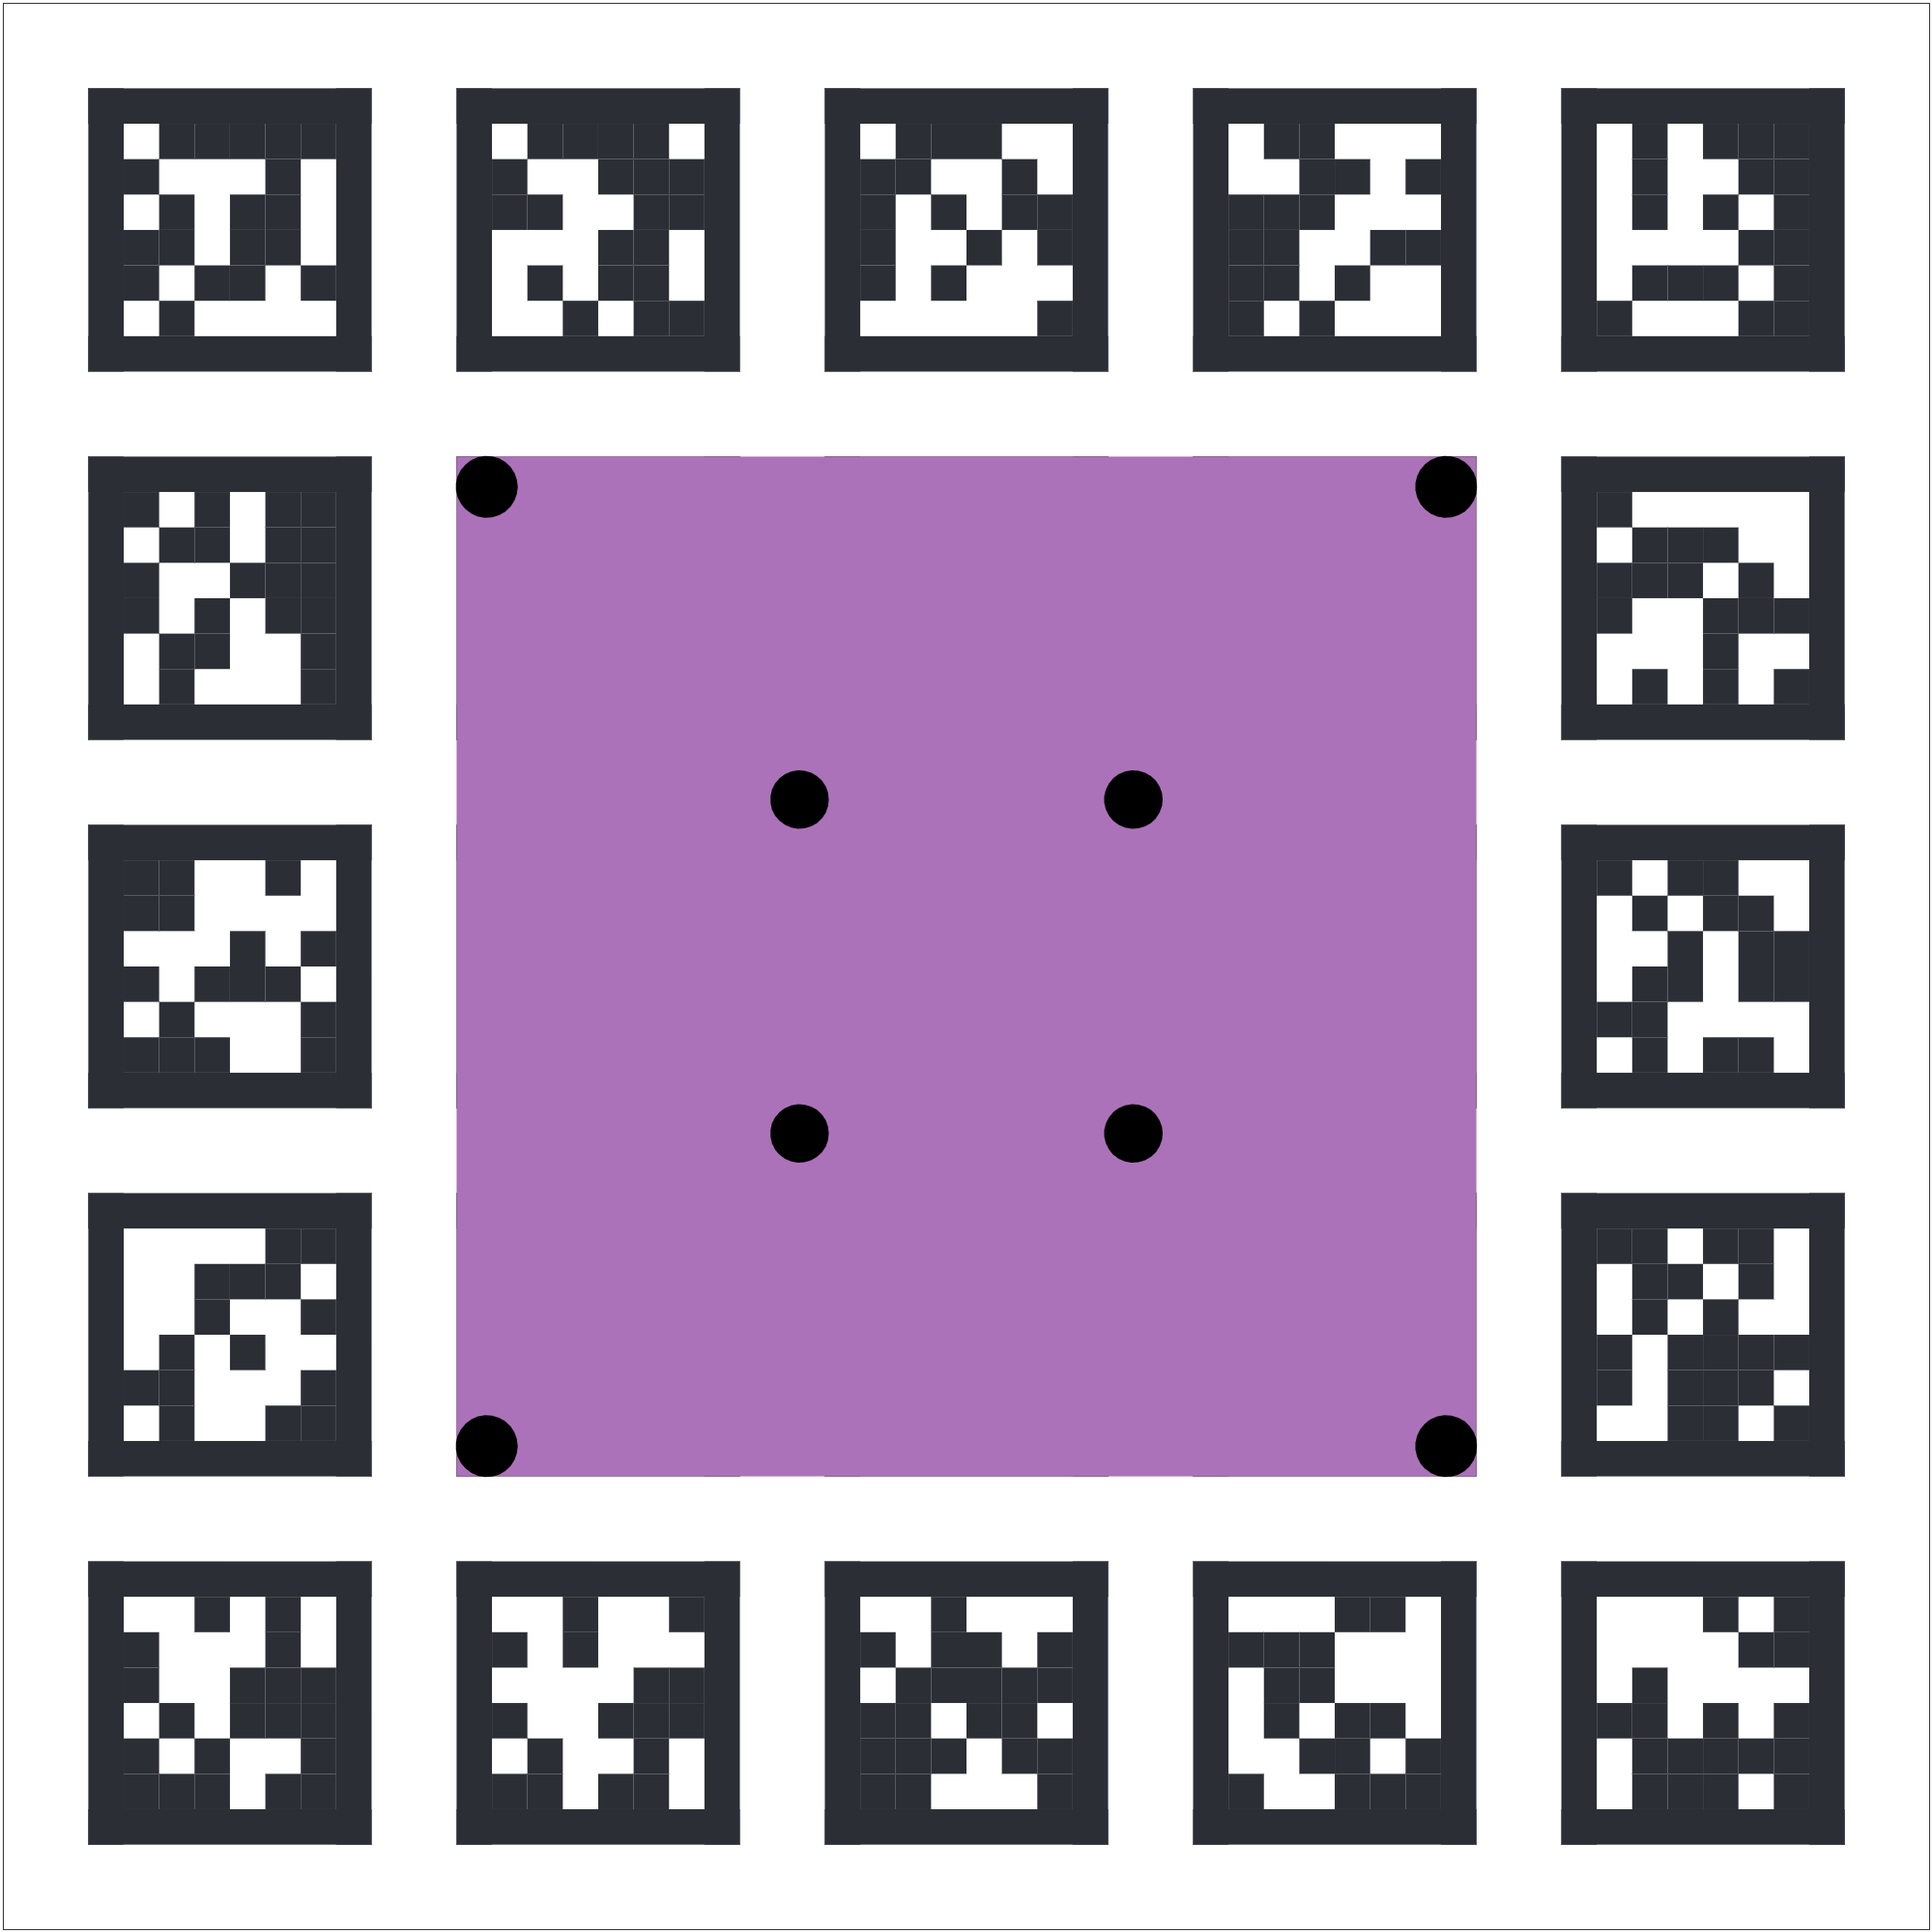 -->

<div>
    <center>
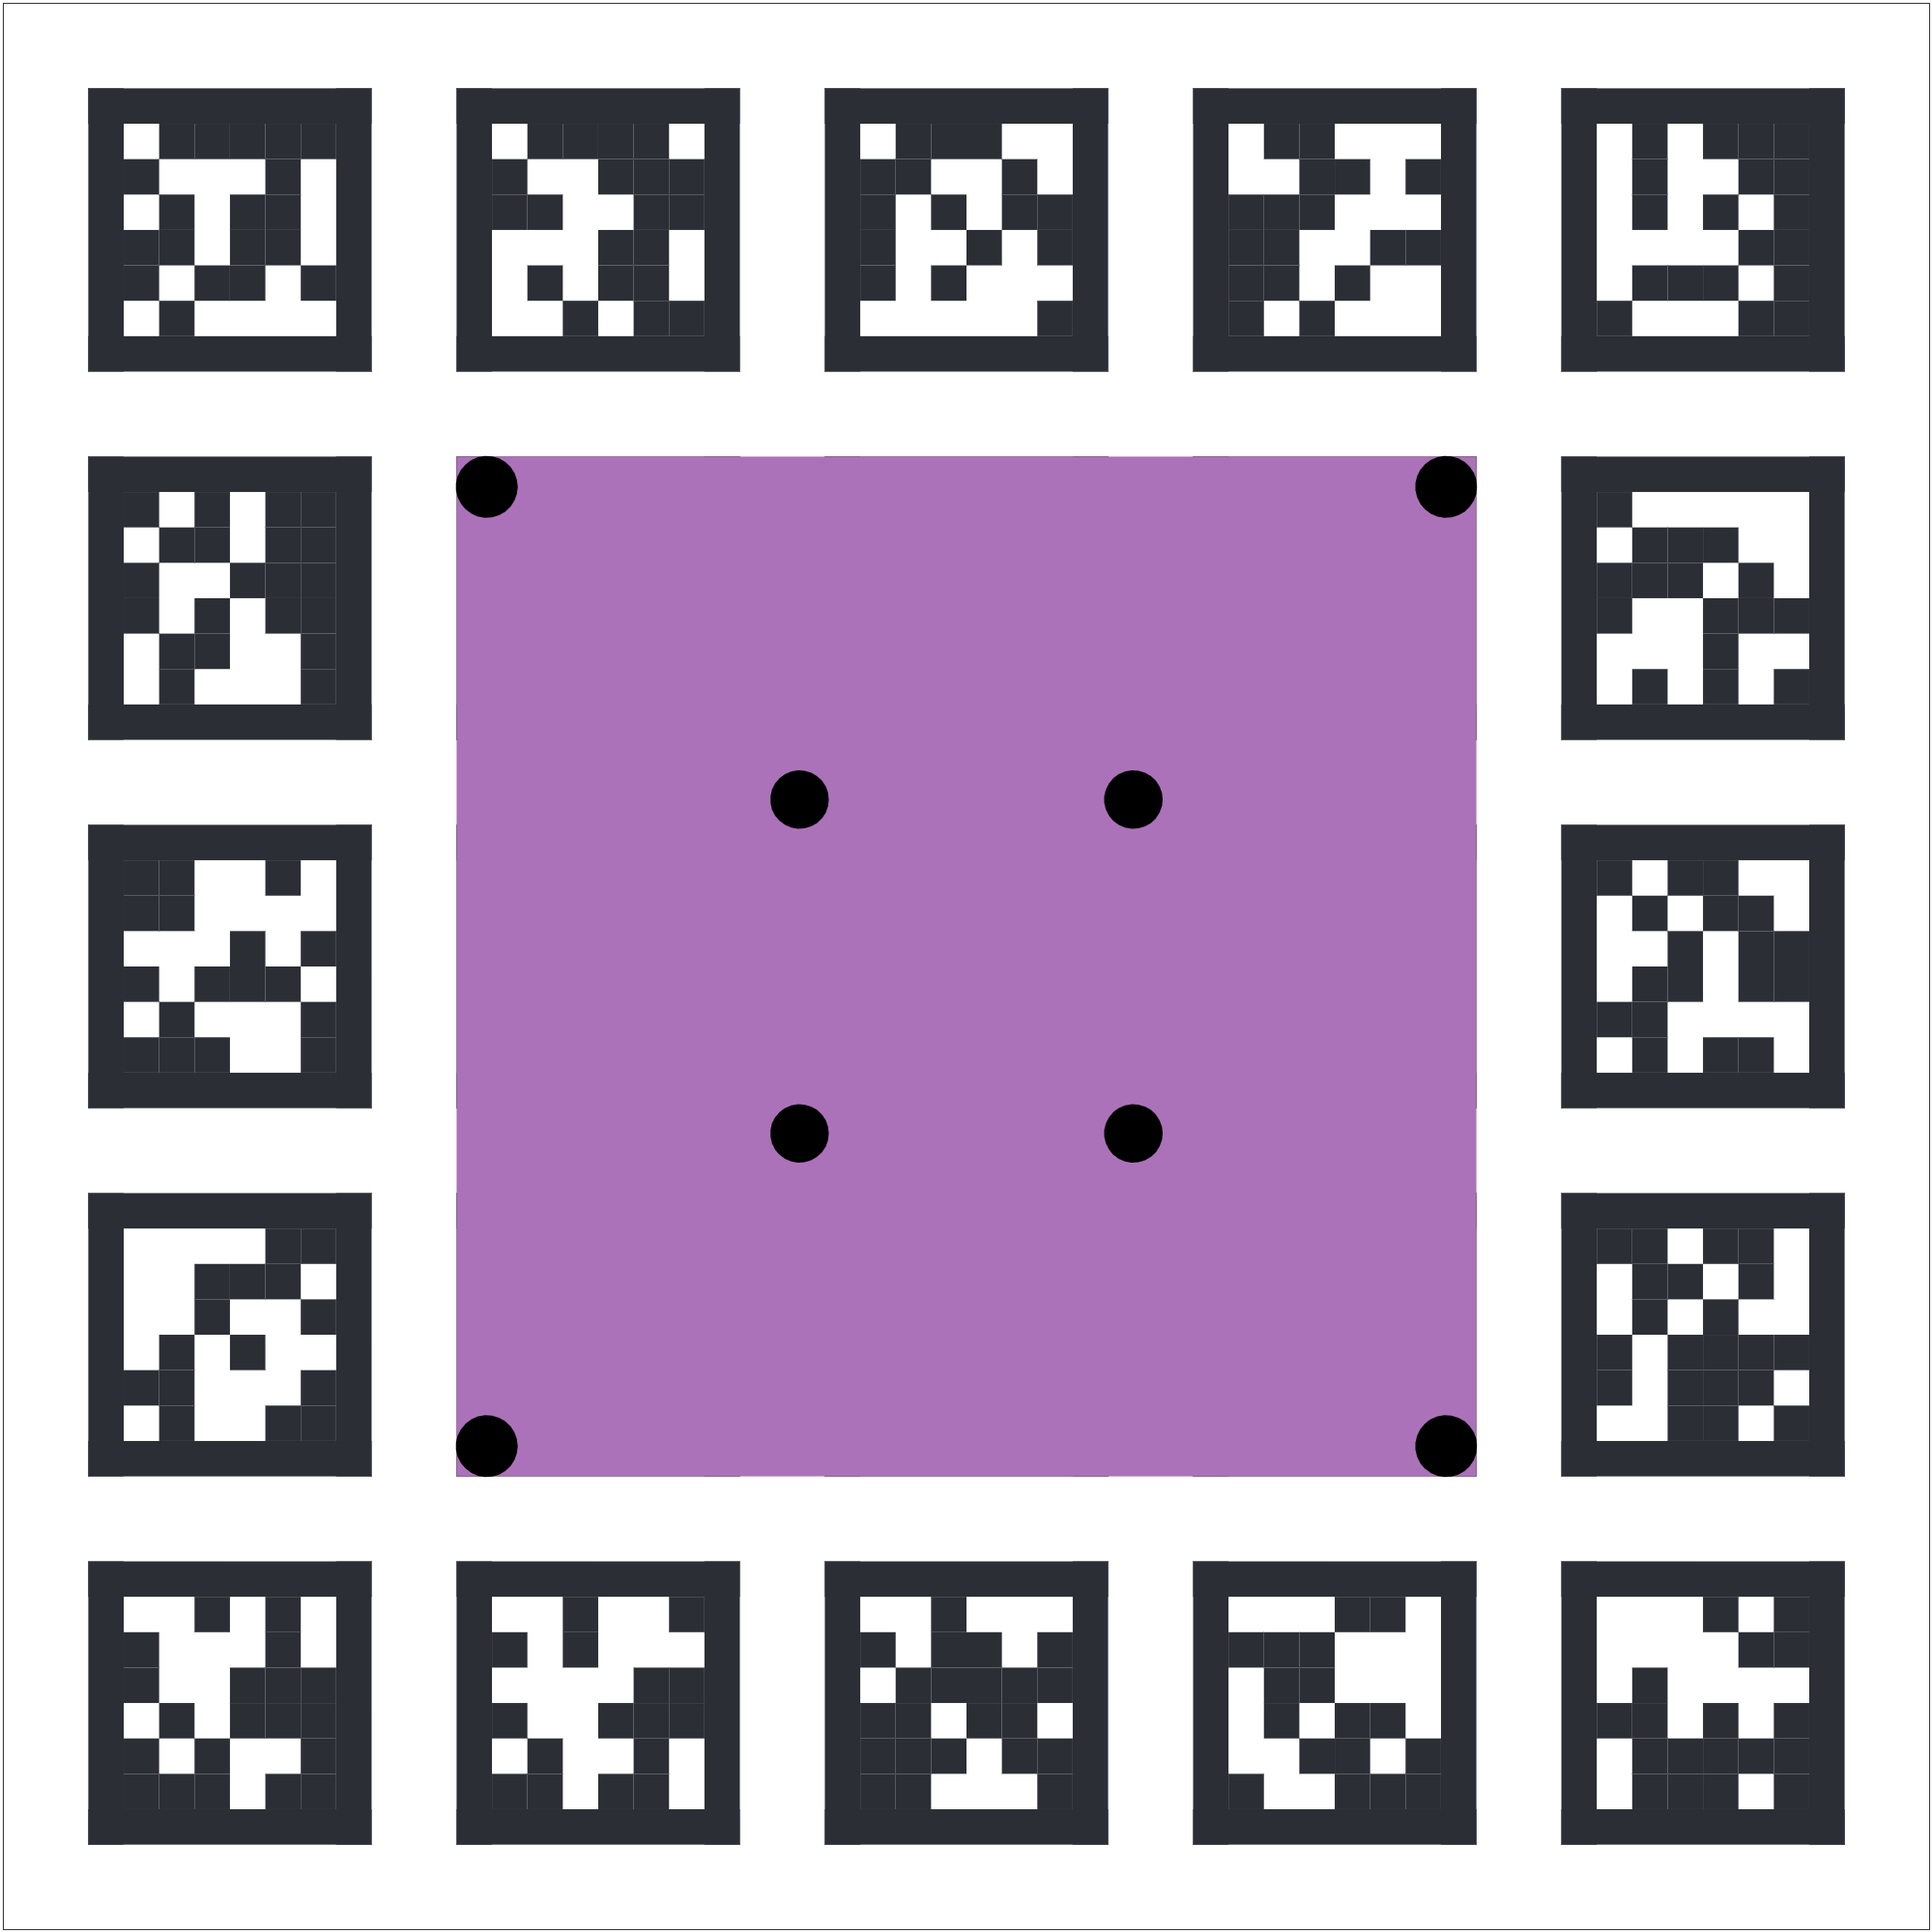
    </center>
</div>

In [3]:
# Define revelant Tagboard grid dimensions, etc. 
tagboard_thickness = 0.125 
plate_thickness = 1
inch_to_m = 2.54 * 0.01
TAGBOARD_Z_OFFSET_FROM_BASE = (tagboard_thickness - plate_thickness) * inch_to_m  

# NOTE: not to scale
tagboard_map = {
    0: np.array([[-1.5, 1.5, 0], [1.5, 1.5, 0], [1.5, -1.5, 0], [-1.5, -1.5, 0]]),              # Tag 0
    1: np.array([[2.5, 1.5, 0],  [5.5, 1.5, 0], [5.5, -1.5, 0], [2.5, -1.5, 0]]),               # Tag 1
    2: np.array([[6.5, 1.5, 0],  [9.5, 1.5, 0], [9.5, -1.5, 0], [6.5, -1.5, 0]]),               # Tag 2
    3: np.array([[10.5, 1.5, 0],  [13.5, 1.5, 0], [13.5, -1.5, 0], [10.5, -1.5, 0]]),           # Tag 3
    4: np.array([[14.5, 1.5, 0],  [17.5, 1.5, 0], [17.5, -1.5, 0], [14.5, -1.5, 0]]),           # Tag 4

    5: np.array([[-1.5, -2.5, 0], [1.5, -2.5, 0], [1.5, -5.5, 0], [-1.5, -5.5, 0]]),            # Tag 5
    9: np.array([[14.5, -2.5, 0], [17.5, -2.5, 0], [17.5, -5.5, 0], [14.5, -5.5, 0]]),          # Tag 9

    10: np.array([[-1.5, -6.5, 0], [1.5, -6.5, 0], [1.5, -9.5, 0], [-1.5, -9.5, 0]]),           # Tag 10
    14: np.array([[14.5, -6.5, 0], [17.5, -6.5, 0], [17.5, -9.5, 0], [14.5, -9.5, 0]]),         # Tag 14

    15: np.array([[-1.5, -10.5, 0], [1.5, -10.5, 0], [1.5, -13.5, 0], [-1.5, -13.5, 0]]),       # Tag 15
    19: np.array([[14.5, -10.5, 0], [17.5, -10.5, 0], [17.5, -13.5, 0], [14.5, -13.5, 0]]),     # Tag 14

    20: np.array([[-1.5, -14.5, 0], [1.5,   -14.5, 0], [1.5,  -17.5, 0], [-1.5, -17.5, 0]]),    # Tag 20
    21: np.array([[2.5,  -14.5, 0],  [5.5,  -14.5, 0], [5.5,  -17.5, 0], [2.5,  -17.5, 0]]),    # Tag 21
    22: np.array([[6.5,  -14.5, 0],  [9.5,  -14.5, 0], [9.5,  -17.5, 0], [6.5,  -17.5, 0]]),    # Tag 22
    23: np.array([[10.5, -14.5, 0],  [13.5, -14.5, 0], [13.5, -17.5, 0], [10.5, -17.5, 0]]),    # Tag 23
    24: np.array([[14.5, -14.5, 0],  [17.5, -14.5, 0], [17.5, -17.5, 0], [14.5, -17.5, 0]]),    # Tag 24
}

tag_size = 3 #1.06 in
cm_scale = .01 # meters to centimeters
tagboard_map = {k:v*cm_scale for k, v in tagboard_map.items()}


# Detect april tags
at_detector = Detector(families='tag36h11',
                          nthreads=1,
                          quad_decimate=1.0,
                          quad_sigma=0.0,
                          refine_edges=1,
                          decode_sharpening=0.25,
                          debug=0)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
tags = at_detector.detect(img_gray, estimate_tag_pose=True, camera_params=camera_params, tag_size=tag_size)


# Make sure the ordering of points and pixels are consistent
def get_tag(tags, id):
    for t in tags:
        if t.tag_id == id:
            return t
            
_, P, pix_corners = zip(*[(k, v, get_tag(tags, k).corners) for k, v in tagboard_map.items()])

R_tag0_in_cam = get_tag(tags, 0).pose_R
R_tag  = np.diag([1, -1, 1])
P = np.stack(P).reshape(-1, 3)
P = P @ R_tag @ R_tag0_in_cam
pix_corners = np.stack(pix_corners).reshape(-1, 2)

In [4]:
# NOTE: There is distortion and there is a notable difference when it is not accounted for... SO USE DISTORTION
_, r, t = cv2.solvePnP(P, pix_corners, K, distortion_coefficients, cv2.SOLVEPNP_ITERATIVE)
T_tagboard_in_cam = make_T(r, t)
r, t

(array([[3.15235317e+00],
        [2.51609663e-03],
        [1.08857906e-02]]),
 array([[0.05136056],
        [0.0452632 ],
        [1.51409577]]))

# Sanity Check $T^{camera}_{tagboard}$ by projecting tagboard coordinates into pixels
$$ \large \begin{bmatrix}
u \\
v \\
1 
\end{bmatrix} = K \cdot \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix} \cdot T^{camera}_{tagboard} \cdot \begin{bmatrix} X \\
Y \\
Z \\
1 \end{bmatrix}  $$

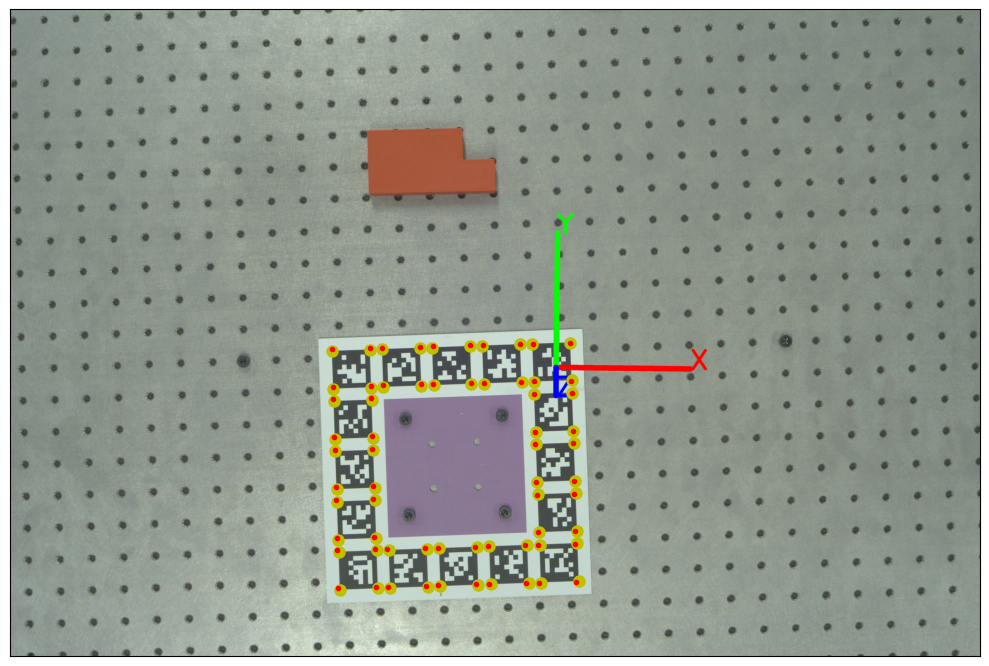

In [5]:
# Get 3D tagboard coordinates
P_h = np.column_stack([P, np.ones(P.shape[0])])

# Project 3D coordinates in tagboard frame to pixels
reprojected_pix = K @ np.eye(3, 4) @ T_tagboard_in_cam @ P_h.T
reprojected_pix /= reprojected_pix[2]
reprojected_pix = (reprojected_pix.T)[:, :2]

R, t = T_tagboard_in_cam[:3, :3], T_tagboard_in_cam[:3, 3]
# Plot reference and reprojected pixels
img_with_axis = draw_axis(img.copy(), R, t, K)
plot_im_with_circle(img_with_axis, pix_corners, reprojected_pix)

## Calculate reprojection error

mean error (pixels) = 9.29
min error (pixels) = 1.05
max error (pixels) = 15.27
median error (pixels) = 10.40


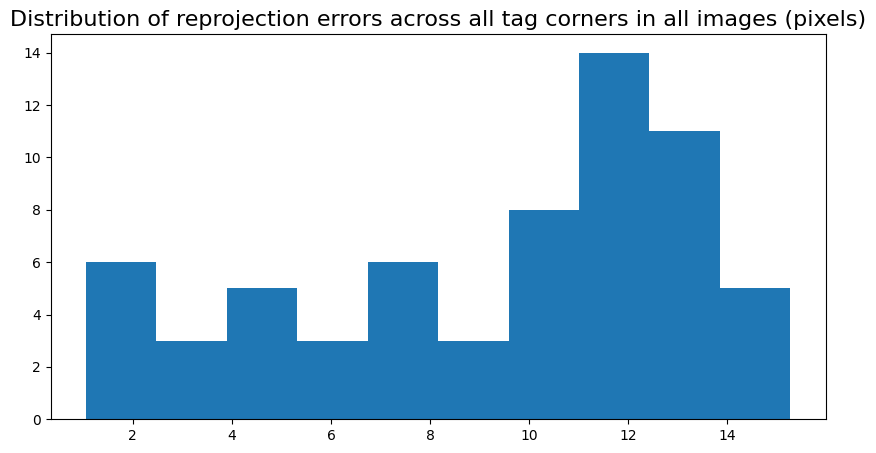

In [6]:
# Calculate reprojection error
reprojected_errs = np.sqrt(np.sum((pix_corners - reprojected_pix)**2, axis=1))
plt.figure(figsize=(10, 5))
plt.hist(reprojected_errs)
plt.title('Distribution of reprojection errors across all tag corners in all images (pixels)',  fontsize=16)

print(f'mean error (pixels) = {np.mean(reprojected_errs):.2f}')
print(f'min error (pixels) = {np.min(reprojected_errs):.2f}')
print(f'max error (pixels) = {np.max(reprojected_errs):.2f}')
print(f'median error (pixels) = {np.median(reprojected_errs):.2f}')

## Calculate relative error in z positon
[Our Extrinsic calibration notebook][notebook] approximates $T_{robot}^{camera}$. The approximated $T_{robot}^{camera}$'s `z` position can be treated as reference for the approximated $T_{tagboard}^{camera}$ in this notebook. 


$T_{robot}^{camera}$'s origin is the base of the robot. Below the robot base is a `8" x 8" x 1"` alluminum plate. The alluminum plate is `1"` from the breadboard surface and the tagboard is `0.125"`. So we the tagboard's `z` value should be `0.875"` below the robot base.

<div>
    <center>
        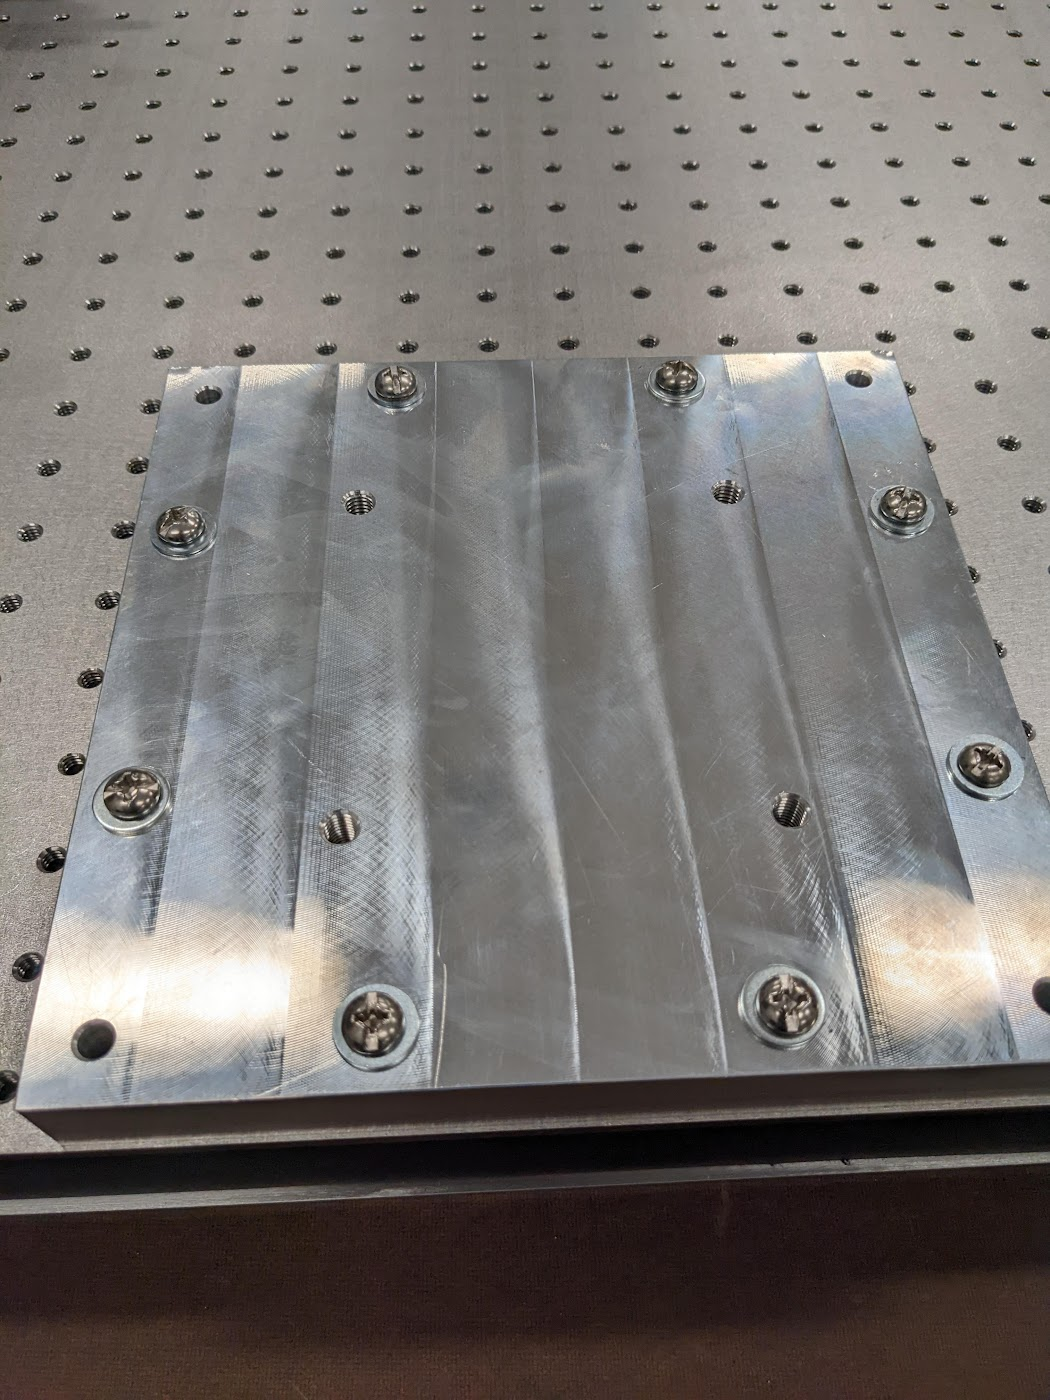
        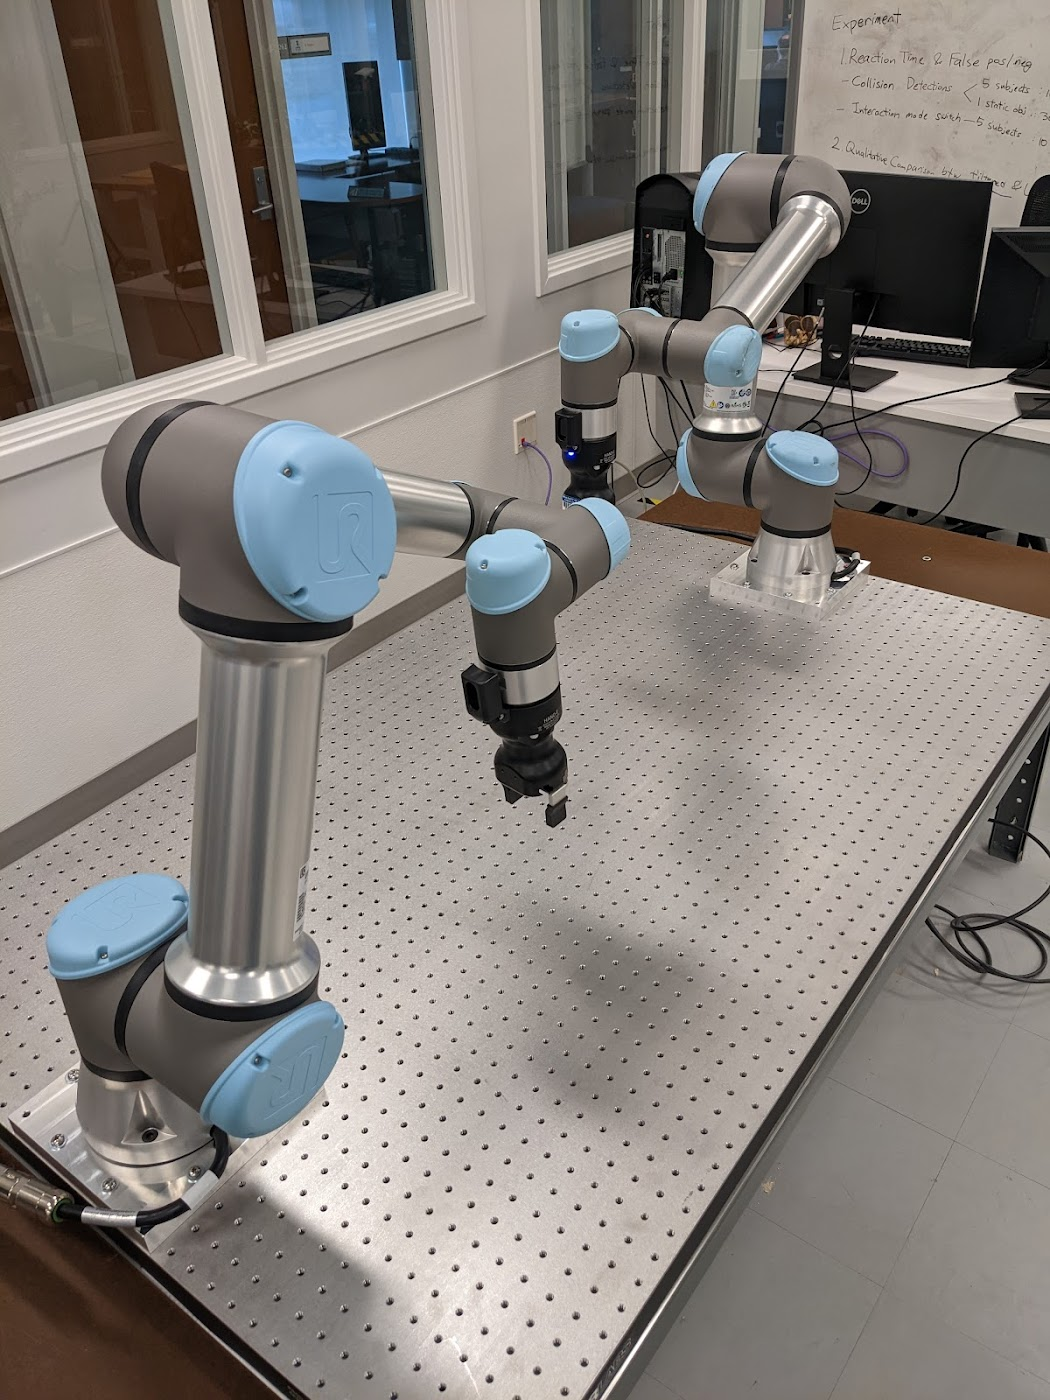
    </center>
</div> 

[notebook]:https://github.com/cobot-factory/ur5e_collab_ws/blob/main/src/Extrinsic_calibration.ipynb

In [7]:
# Calculate error in Z estimate
reference_z = T_camera_in_base[2,3] - TAGBOARD_Z_OFFSET_FROM_BASE
est_z = T_tagboard_in_cam[2,3]
print(f"Relative RSME error for z: {np.sqrt((reference_z - est_z) ** 2)}")

Relative RSME error for z: 0.002700291236734431


In [8]:
reference_z, est_z, TAGBOARD_Z_OFFSET_FROM_BASE

(1.5167960647914274, 1.514095773554693, -0.022225)

In [9]:
(1 - 0.125)

0.875

In [10]:
np.save("./T_tagboard_in_cam.npy", T_tagboard_in_cam)